# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [26]:
import datetime
import pickle

In [3]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# explore the portfolio
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
def clean_portfolio(portfolio):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # change the duration from day to hour
    portfolio['duration'] = portfolio['duration'] * 24
    
    # apply one hot encoding to channels column
    portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(portfolio['offer_type'])
    
    # drop the channels and offer_type column
    portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    portfolio = pd.concat([portfolio, offer_type], axis=1, sort=False)
    
    return portfolio

In [4]:
portfolio = clean_portfolio(portfolio)

In [5]:
portfolio

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [6]:
# explore the profile 
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
profile.shape

(17000, 5)

In [24]:
def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    profile['memberdays'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    
    return profile

In [27]:
profile = clean_profile(profile)

In [28]:
profile.describe()

,age,became_member_on,income,memberdays
count,14825.000000,1.482500e+04,14825.000000,14825.000000
mean,54.393524,2.016689e+07,65404.991568,828.478988
std,17.383705,1.188565e+04,21598.299410,419.205158
min,18.000000,2.013073e+07,30000.000000,306.000000
25%,42.000000,2.016052e+07,49000.000000,514.000000
50%,55.000000,2.017080e+07,64000.000000,664.000000
75%,66.000000,2.017123e+07,80000.000000,1103.000000
max,101.000000,2.018073e+07,120000.000000,2129.000000


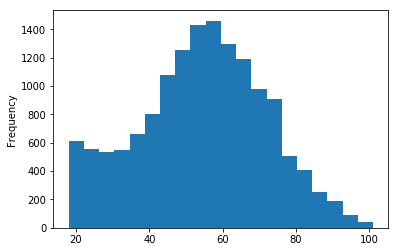

In [29]:
profile['age'].plot(kind='hist', bins=20)

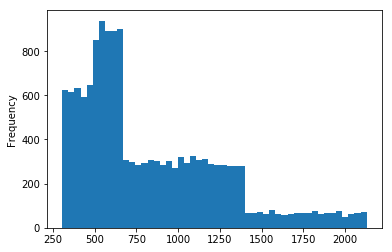

In [30]:
profile['memberdays'].plot(kind='hist', bins=50)

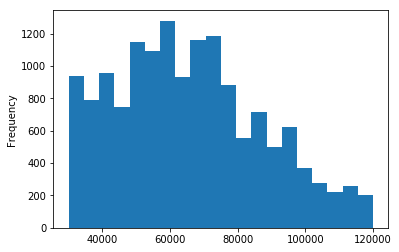

In [31]:
profile['income'].plot(kind='hist', bins=20)

In [32]:
profile.head()

,age,became_member_on,gender,id,income,memberdays
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,682
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,749
5,68.0,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0,397
8,65.0,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0,473
12,58.0,20171111,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,563


In [19]:
# explore transcript
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [20]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [94]:
transcript[transcript['person']=='0009655768c64bdeb2e877511632db8f']

,event,person,time,value
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16}
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57}
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}


In [99]:
offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]

In [101]:
offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])

d:\data science\data visualization\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [102]:
offer.head()

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [103]:
offer['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [105]:
offer[offer['event']=='offer completed'].count()

event       33579
person      33579
time        33579
value       33579
offer_id    33579
dtype: int64

In [109]:
def create_user_item_matrix():
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    None
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    
    for id in user_item_matrix.columns:
        print("Now processing: ", id)
        num = 0
        for person in user_item_matrix.index[:1000]:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, id] = 0
                
    fh = open('user_item_matrix.p', 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [110]:
user_item_matrix = create_user_item_matrix()

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
Now processing:  2906b810c7d4411798c6938adc9daaa5
finished  5.884429798752501 %
Now processing:  3f207df678b143eea3cee63160fa8bed
finished  5.884429798752501 %
Now processing:  4d5c57ea9a6940dd891ad53e9dbe8da0
finished  5.884429798752501 %
Now processing:  5a8bc65990b245e5a138643cd4eb9837
finished  5.884429798752501 %
Now processing:  9b98b8c7a33c4b65b9aebfe6a799e6d9
finished  5.884429798752501 %
Now processing:  ae264e3637204a6fb9bb56bc8210ddfd
finished  5.884429798752501 %
Now processing:  f19421c1d4aa40978ebb69ca19b0e20d
finished  5.884429798752501 %
Now processing:  fafdcd668e3743c1bb461111dcafc2a4
finished  5.884429798752501 %


In [111]:
user_item_matrix

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,NaN,0.0,1.0,NaN,1.0,NaN
003d66b6608740288d6cc97a6903f4f0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,2.0
00426fe3ffde4c6b9cb9ad6d077a13ea,0.0,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,1.0
004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.0,1.0
004c5799adbf42868b9cff0396190900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,1.0


In [112]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat 

In [113]:
user_item_matrix.sum()

offer_id
0b1e1539f2cc45b7b9fa7c272da2e1d7     87.0
2298d6c36e964ae4a3e7e9706d1fb8c2    243.0
2906b810c7d4411798c6938adc9daaa5    125.0
3f207df678b143eea3cee63160fa8bed      0.0
4d5c57ea9a6940dd891ad53e9dbe8da0    161.0
5a8bc65990b245e5a138643cd4eb9837      0.0
9b98b8c7a33c4b65b9aebfe6a799e6d9    131.0
ae264e3637204a6fb9bb56bc8210ddfd    146.0
f19421c1d4aa40978ebb69ca19b0e20d    215.0
fafdcd668e3743c1bb461111dcafc2a4    255.0
dtype: float64

In [114]:
# Create user-by-item matrix - nothing to do here
train_data_np = np.array(user_item_matrix)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.824916
2 		 0.302542
3 		 0.282457
4 		 0.271429
5 		 0.264850
6 		 0.260495
7 		 0.257250
8 		 0.254542
9 		 0.252067
10 		 0.249662
11 		 0.247237
12 		 0.244737
13 		 0.242133
14 		 0.239402
15 		 0.236531
16 		 0.233510
17 		 0.230333
18 		 0.226995
19 		 0.223493
20 		 0.219826
21 		 0.215995
22 		 0.212003
23 		 0.207856
24 		 0.203560
25 		 0.199125
26 		 0.194564
27 		 0.189888
28 		 0.185115
29 		 0.180260
30 		 0.175341
31 		 0.170379
32 		 0.165391
33 		 0.160397
34 		 0.155416
35 		 0.150467
36 		 0.145566
37 		 0.140728
38 		 0.135969
39 		 0.131301
40 		 0.126734
41 		 0.122276
42 		 0.117937
43 		 0.113720
44 		 0.109630
45 		 0.105670
46 		 0.101841
47 		 0.098143
48 		 0.094576
49 		 0.091138
50 		 0.087827
51 		 0.084640
52 		 0.081575
53 		 0.078627
54 		 0.075793
55 		 0.073070
56 		 0.070453
57 		 0.067939
58 		 0.065523
59 		 0.063202
60 		 0.060972
61 		 0.058828
62 		 0.056768
63 		 0.054788
64 		 0

In [115]:
def predict_complete(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    # Use the training data to create a series of users and movies that matches the ordering in training data
    user_ids_series = np.array(user_item_matrix.index)
    offer_ids_series = np.array(user_item_matrix.columns)
    
    # User row and Movie Column
    user_row = np.where(user_ids_series == user_id)[0][0]
    offer_col = np.where(offer_ids_series == offer_id)[0][0]
    
    # Take dot product of that row and column in U and V to make prediction
    pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
    
    return pred

In [121]:
for offer in user_item_matrix.columns:
    pred_val = predict_complete(user_mat, offer_mat, '00b18b535d6d4f779dea4dc9ac451478', offer)
    print(pred_val)

0.010306997760723635
2.003447447751803
-0.20366980544890068
2.967809922775497e-24
0.9582099754785393
-2.3988322849043202e-26
0.16560393504444548
-0.01643289783285451
0.4477227384329676
0.9963114445201111


In [80]:
user_item_matrix = pd.read_pickle('user_item_matrix.p')


       age  became_member_on  income  memberdays
count  0.0               0.0     0.0         0.0
mean   NaN               NaN     NaN         NaN
std    NaN               NaN     NaN         NaN
min    NaN               NaN     NaN         NaN
25%    NaN               NaN     NaN         NaN
50%    NaN               NaN     NaN         NaN
75%    NaN               NaN     NaN         NaN
max    NaN               NaN     NaN         NaN
       age  became_member_on  income  memberdays
count  0.0               0.0     0.0         0.0
mean   NaN               NaN     NaN         NaN
std    NaN               NaN     NaN         NaN
min    NaN               NaN     NaN         NaN
25%    NaN               NaN     NaN         NaN
50%    NaN               NaN     NaN         NaN
75%    NaN               NaN     NaN         NaN
max    NaN               NaN     NaN         NaN
       age  became_member_on  income  memberdays
count  0.0               0.0     0.0         0.0
mean   NaN          

In [120]:
for offer_id in user_item_matrix.columns:
    print(offer_id)
    print(profile[profile['id'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index))].describe())

0b1e1539f2cc45b7b9fa7c272da2e1d7
             age  became_member_on        income   memberdays
count  80.000000      8.000000e+01      80.00000    80.000000
mean   57.512500      2.016479e+07   74187.50000   910.025000
std    13.486039      1.018602e+04   17593.21917   360.650993
min    25.000000      2.013102e+07   35000.00000   311.000000
25%    49.000000      2.016041e+07   63000.00000   640.000000
50%    57.000000      2.016116e+07   75500.00000   911.500000
75%    67.000000      2.017084e+07   85250.00000  1139.500000
max    93.000000      2.018072e+07  117000.00000  2043.000000
2298d6c36e964ae4a3e7e9706d1fb8c2
              age  became_member_on         income   memberdays
count  188.000000      1.880000e+02     188.000000   188.000000
mean    53.622340      2.016481e+07   67047.872340   895.393617
std     17.050442      1.071928e+04   19946.260576   387.624680
min     19.000000      2.013101e+07   31000.000000   311.000000
25%     40.000000      2.016038e+07   51000.000000   585